In [1]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
#import torch

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence


## Import functions for the experiment : 

from experiment_functions import *
from IPLA_Exp_Functions import *
from IPLA_functions_MMLE_V2 import *

### MMLE Experiment with Banana Distribution

In this example, we will work on $ \mathbb{R}^{dx} $ Let us assume the following “banana” prior:

$ p(x) \propto \exp\left(-\frac{x_1^2}{10} - \frac{x_2^2}{10} - 2(x_2 - x_1^2)^2\right), $

where $ x \in \mathbb{R}^{dx} $ We would like to then use the following likelihood:

$ p(y|x) = \mathcal{N}(y; Hx, \sigma^2 I), $

where $ H \in \mathbb{R}^{dx} $ and $ y \in \mathbb{R} $ 

Our first goal is to sample from $ p(x|y) $ efficiently given the parameter $H$. Then, we will proceed to estimate the Maximum Marginal Likelihood of the model, given the observation. 

In a second time, if the model is not identifiable and $H$ is too difficult to estimate, we will consider the parameter to be : 
$\theta^* = (-\frac{1}{10}, -\frac{1}{10}, -2)$, and the prior distribution is : 
$p_\theta(x) \propto \exp(\theta^T.(x_1^2, x_2^2, (x_2-x_1^2)^2)) $

------------------------------------------------------------------------------------------------------------------------------------------
Here is the shape of the prior "banana" distribution :

In [70]:
theta_star = np.array([-0.1, -0.1, -2])

In [73]:
def bar_p(x):
    return np.exp((x[0]**2) * theta_star[0] + (x[1]**2) * theta_star[1] + theta_star[2] * (x[1] - x[0]**2)**2)

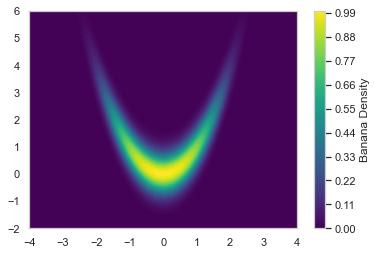

In [94]:
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb) # evaluate barp on this grid
Z_bb = np.zeros((100, 100)) 

for i in range(100):
    for j in range(100):
        Z_bb[i, j] = bar_p([X_bb[i, j], Y_bb[i, j]])
# plot barp
contour = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='viridis')
plt.colorbar(contour, label = 'Banana Density')
plt.show()

The gradient of the prior's log-density is given by : 
$\nabla_x \log p_\theta(x) = (2\theta_1 x_1 - 4\theta_3 x_1 (x_2 - x_1^2)  ;  2\theta_2 x_2 + 2 \theta_3 (x_2 - x_1^2))$

In [96]:
def grad_banana_gen(x, theta) : 

    grad_x = np.zeros_like(x)
    
    grad_x[:, 0] = 2 * theta[0] * x[:, 0] - 4 * theta[2] * (x[:, 1] - x[:, 0]**2) * x[:, 0]
    
    grad_x[:, 1] = 2 * theta[1] * x[:, 1] + 2 * theta[2] * (x[:, 1] - x[:, 0]**2)
    
    return grad_x

In [102]:
def grad_banana(x):

    grad = -x/5

    grad[:, 0] += 8 * x[:, 0] * (x[:, 1] - x[:, 0]**2)

    grad[:, 1] -= 4 * (x[:, 1] - x[:, 0]**2)

    return grad


No handles with labels found to put in legend.


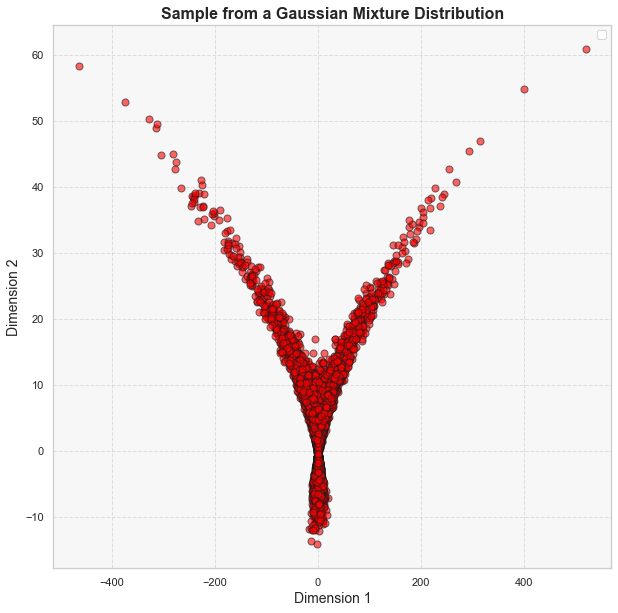

No handles with labels found to put in legend.


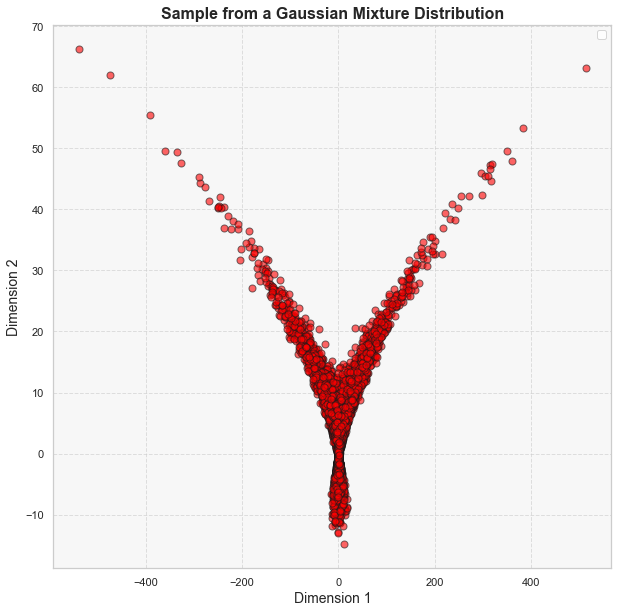

In [103]:
sample_init = np.random.randn(10000, 2)

plot_sample_dx(grad_banana_gen(sample_init, theta_star))

sample_init = np.random.randn(10000, 2)

plot_sample_dx(grad_banana(sample_init))

We define ULA to be able to sample from this prior distribution 

In [111]:
def ULA_banana(sample, nb_iter, step_size, plot = False):

    sample_size = sample.shape[0]

    dim_var = sample.shape[1]

    for i in range(nb_iter) :

        grad = grad_banana(sample)

        sample += step_size * grad + np.sqrt(2*step_size) * np.random.randn(sample_size, dim_var) #MOINS Gradient du potentiel
    
    if plot : 

        plot_sample_dx(sample, 'Banana Prior')

    return sample

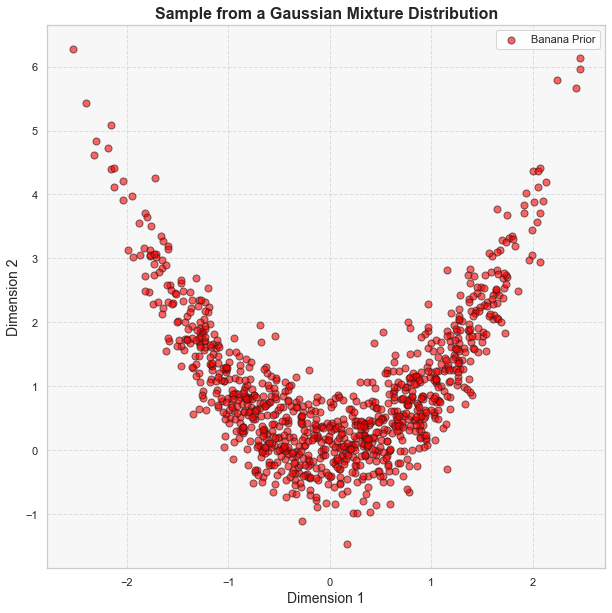

Nb NaN 0


In [113]:
sample_init = np.random.randn(1000, 2)

x = ULA_banana(sample_init, 50000, 0.001, plot=True)

print(f'Nb NaN {np.sum(np.isnan(x))}')

The drift term of the prior distribution is superlinear, at least in some directions : 

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_21801/1545989476.py:5: RuntimeWarning: invalid value encountered in true_divide
  grad[i] = grad_banana(np.array([[0.1*i, 0.1*i], [0.1*i, 0.1*i]]))[0] / np.linalg.norm(np.array([0.1*i, 0.1*i]))
No handles with labels found to put in legend.


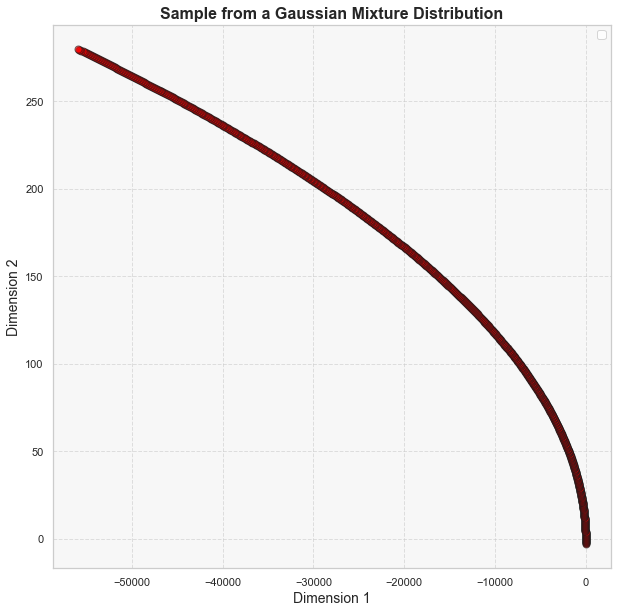

In [117]:
grad = np.zeros((1000, 2))

for i in range(1000):

    grad[i] = grad_banana(np.array([[0.1*i, 0.1*i], [0.1*i, 0.1*i]]))[0] / np.linalg.norm(np.array([0.1*i, 0.1*i]))
    #grad[i] = grad_banana(np.array([[0.1*i, 0.1*i], [0.1*i, 0.1*i]]))[0]

plot_sample_dx(grad)

As in this exercise, we set $y_{obs} = 1$, $\sigma_y = 0.05$ and $H = (1, 0)$, then we can try to sample from the posterior distribution given by :

$p_{\theta}(x) \propto p_\theta(x) p(y \mid x)$

In [172]:
y_obs = 1
sigma_y = 0.05
H = np.array([1, 0])

Now ULA used to sample from posterior distribution

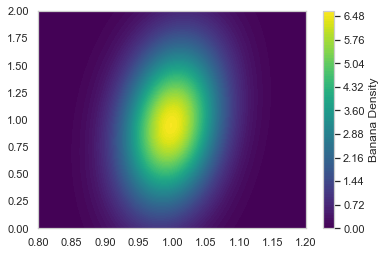

In [138]:
x_axis = np.linspace(0.8, 1.2, 100)
y_axis = np.linspace(0, 2, 100)
X_axis, Y_axis = np.meshgrid(x_axis, y_axis) # evaluate barp on this grid
Z = np.zeros((100, 100)) 

for i in range(100):
    for j in range(100):
        Z[i, j] = bar_p([X_axis[i, j], Y_axis[i, j]]) * norm.pdf(y_obs, H @ np.array([X_axis[i, j], Y_axis[i, j]]), sigma_y)

# plot barp
contour = plt.contourf(X_axis, Y_axis, Z, 100, cmap='viridis')
plt.colorbar(contour, label = 'Banana Density')
plt.show()

In [272]:
def ULA_post_banana(sample, nb_iter, step_size, theta, y_obs, sigma_y, plot = False):

    sample_size = sample.shape[0]

    dim_var = sample.shape[1]

    for i in tqdm(range(nb_iter)) :

        grad = grad_banana(sample)

        grad += (1/sigma_y**2) * (y_obs - theta[:, np.newaxis].T * sample) * theta

        sample += step_size * grad + np.sqrt(2*step_size) * np.random.randn(sample_size, dim_var) #MOINS Gradient du potentiel

        if np.sum(np.isnan(sample)) // 2 > 850: 
            return 'Too much NaN'
    
    if plot: 
        plot_sample_dx(sample, 'Banana Prior')

    return sample

We sample from the posterior distribution via ULA : 

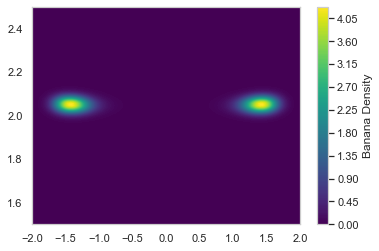

In [268]:
x_axis = np.linspace(-2, 2, 200)
y_axis = np.linspace(1.5, 2.5, 200)
X_axis, Y_axis = np.meshgrid(x_axis, y_axis) # evaluate barp on this grid
Z = np.zeros((200, 200)) 

for i in range(200):
    for j in range(200):
        Z[i, j] = bar_p([X_axis[i, j], Y_axis[i, j]]) * norm.pdf(4, np.array([0, 1.95]) @ np.array([X_axis[i, j], Y_axis[i, j]]), sigma_y)

# plot barp
contour = plt.contourf(X_axis, Y_axis, Z, 200, cmap='viridis')
plt.colorbar(contour, label = 'Banana Density')
plt.show()

100%|██████████| 20000/20000 [00:04<00:00, 4569.51it/s]


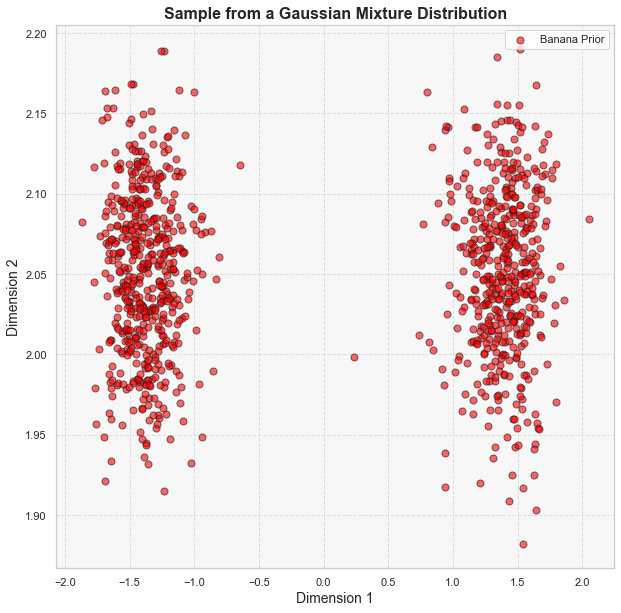

array([[ 1.28393158,  2.06667843],
       [-1.5197399 ,  2.01925858],
       [ 1.42447132,  2.07578757],
       ...,
       [ 1.32783073,  2.01813641],
       [ 1.55321913,  2.10978443],
       [ 1.40541621,  2.11579339]])

In [253]:
sample_init = ULA_banana(np.random.randn(1000, 2), 50000, 0.001) ## Sample from prior
ULA_post_banana(sample_init, 20000, 0.001, np.array([0, 1.95]), 4, 0.05)

Before trying to estimate the maximum marginal likelihood (with H as the parameter) of the observation, we compute the marginal likelihood depending on H to see if the model is identifiable : 

$p_H(y_{obs}) = \int p(x).p_H(y \mid x) dx $

Here, we just plot the distribution of y for H = (3, 2)

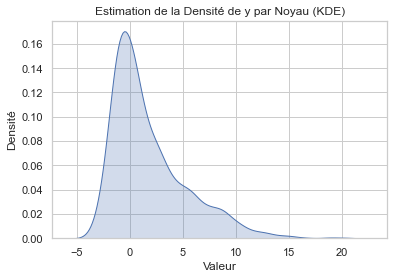

In [261]:
sample_prior = ULA_banana(np.random.randn(3000, 2), 25000, 0.001) ## Sample from prior
sample_noise = np.random.randn(3000) * sigma_y

sample_obs = np.array([3, 2]) @ sample_prior.T + sample_noise

sns.kdeplot(sample_obs, fill=True)
plt.title('Estimation de la Densité de y par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

Here, for $y_{obs} = 1$, we compute the likelihood for several values of H

In [263]:
sample_prior = ULA_banana(np.random.randn(3000, 2), 50000, 0.001) ## Sample from prior

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [05:31<00:00, 11.05s/it]


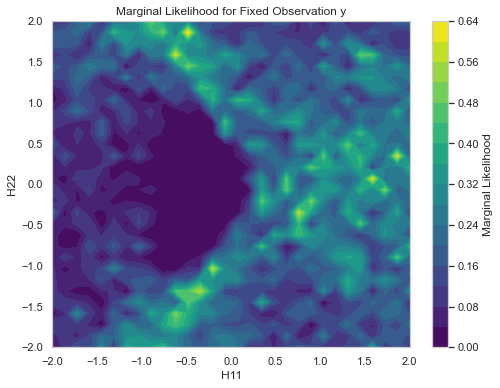

In [157]:
def likelihood(y, x, H, sigma=0.05):
    mean = H @ x
    cov = sigma**2
    return norm.pdf(y, mean, cov)

def marginal_likelihood(y, H, sample_prior):
    likelihoods = [likelihood(y, x, H) for x in sample_prior]
    return np.mean(likelihoods)

H11 = np.linspace(-2, 2, 30)
H22 = np.linspace(-2, 2, 30)
H_grid = np.meshgrid(H11, H22)
Z = np.zeros_like(H_grid[0])

for i in tqdm(range(len(H11))):
    for j in range(len(H22)):
        H = np.array([H11[i], H22[j]])
        Z[i, j] = marginal_likelihood(y_obs, H, sample_prior)

plt.figure(figsize=(8, 6))
contour = plt.contourf(H11, H22, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Marginal Likelihood')
plt.xlabel('H11')
plt.ylabel('H22')
plt.title('Marginal Likelihood for Fixed Observation y')
plt.show()


We adapt the pre-existing function to proceed the particle gradient descent and estimate $H$. 

In [295]:

def PGD_ban(nb_particles, nb_iter, step_size, H_0, sigma_y, y_obs, plot = False, sample_prior = None, coeff_theta = 1) : 
    """
    This function executes the Particle Gradient Descent in the context of our experiment. Given :
    - The number of particles
    - The number of iterations
    - The step size
    - Parameters of the prior distribution
    - The observed data point "y"
    - The initializing H_0
    """

    theta_t = H_0

    dx = H_0.shape[0]

    if sample_prior is None :
        sample = ULA_banana(np.random.randn(nb_particles, dx), 20000, 0.001) ## Sample from prior
    else : 
        sample = np.copy(sample_prior)
    

    theta_traj = np.zeros((nb_iter, dx))

    for i in range(nb_iter) : 

        grad = grad_banana(sample)

        grad += (1/sigma_y**2) * theta_t * (y_obs - theta_t[:, np.newaxis].T * sample)

        sample += step_size * grad + np.sqrt(2*step_size) * np.random.randn(nb_particles, dx)

        ## MAJ du theta
        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_t = theta_t - (step_size * coeff_theta / nb_particles) * grad_theta_update 

        theta_traj[i] = theta_t

        if np.sum(np.isnan(sample)) // dx > 0.9*nb_particles:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        plot_sample_dx(sample, 'Banana Posterior')

        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

    return sample, theta_t, theta_traj

Parait assez plausible de tendre vers $(0, 0.8)$ car c'est la valeur de H pour laquelle obtenir y = 1 est le plus élevé. Le problème étant que cela ne correspond pas à la posterior que l'on observe préalablement. 

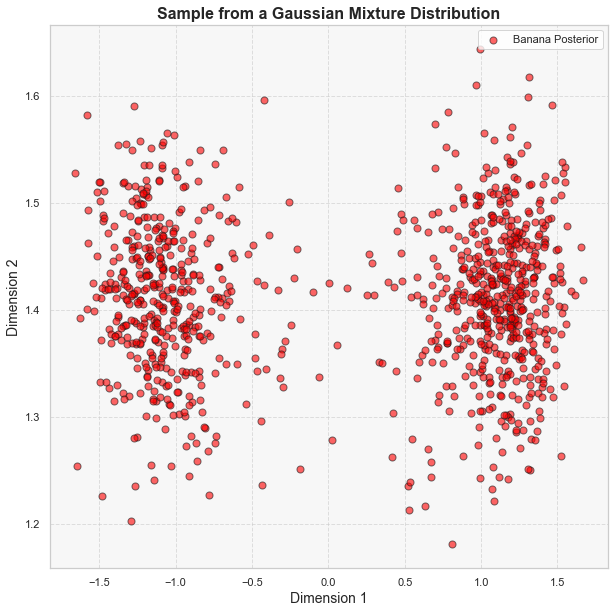

(array([[ 1.38418053,  1.50224626],
        [ 1.03631613,  1.39160491],
        [ 1.22189353,  1.50848484],
        ...,
        [-1.10906372,  1.44228167],
        [-1.37831308,  1.39472695],
        [-1.34267654,  1.43489026]]),
 array([-5.72479826e-04,  7.06966521e-01]),
 array([[ 9.85161854e-02,  1.14427931e-01],
        [ 9.70718022e-02,  1.28222284e-01],
        [ 9.56715720e-02,  1.41415199e-01],
        ...,
        [-6.25434688e-04,  7.06967889e-01],
        [-5.99655366e-04,  7.06966457e-01],
        [-5.72479826e-04,  7.06966521e-01]]))

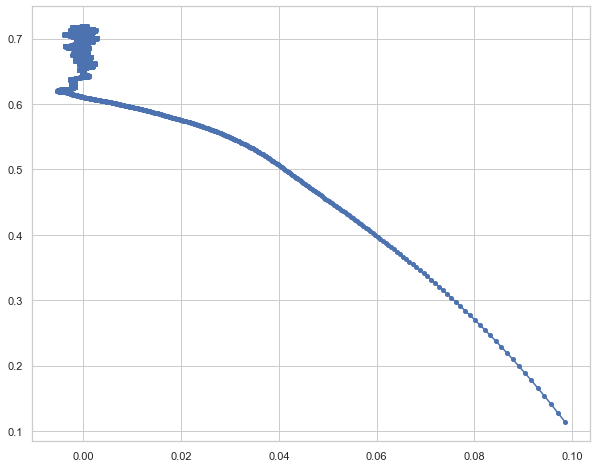

In [269]:
PGD_ban(1000, 20000, 0.00005, np.array([0.1, 0.1]), 0.05, 1, plot = True, sample_prior = None)

Mini test : On regarde si ça converge vers le bon theta en mettant un échantillon de la posterior => converge donc évidemment vers l'exact theta donc tout est bien implémenté. 

Ensuite, on teste plusieurs valeurs initiales de theta et on remarque que cela oriente donc la zone de haute densité marginale vers laquelle on va converger. Mais pas de hasard, cela converge toujours vers le même endroit, à savoir un mode de haute densité dans la direction du theta initial. 

Le fait de faire des warm-starts oriente aussi un peu vers là où on va mais ne change pas fondamentalement. 

Très souvent, un pas trop grand fait diverger le theta mais pas les particles. Donc le fait de différencier les deux pas n'est pas plus mal pour pouvoir avancer plus vite sans divergence. 



In [305]:
sample_init = ULA_banana(np.random.randn(1000, 2), 50000, 0.001) ## Sample from prior
sample_post = ULA_post_banana(sample_init, 20000, 0.001, np.array([0.2, 0.2]), 1, 0.05, plot = False)

100%|██████████| 20000/20000 [00:04<00:00, 4735.06it/s]


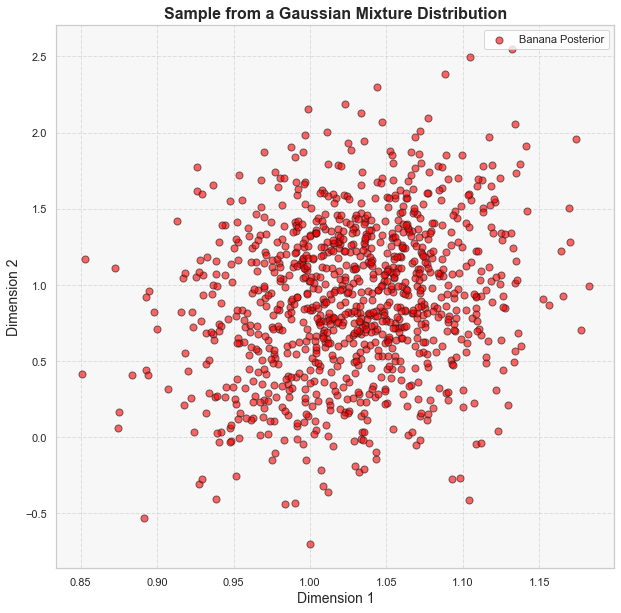

(array([[0.88367637, 0.40874558],
        [1.02382078, 1.4110971 ],
        [1.0426349 , 0.6995406 ],
        ...,
        [0.94056982, 0.7009186 ],
        [1.13522364, 1.0345532 ],
        [1.04618255, 1.6701583 ]]),
 array([ 0.96872473, -0.00260694]),
 array([[ 0.1870306 ,  0.17378484],
        [ 0.17779215,  0.15509987],
        [ 0.17121549,  0.14178707],
        ...,
        [ 0.96867352, -0.00261041],
        [ 0.96869453, -0.00261339],
        [ 0.96872473, -0.00260694]]))

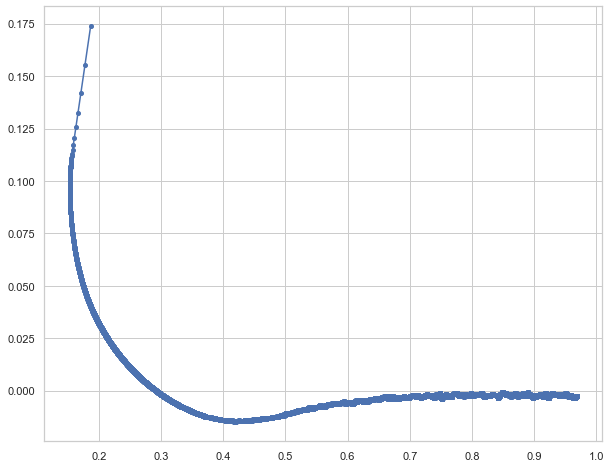

In [308]:
PGD_ban(1000, 35000, 0.0001, np.array([0.2, 0.2]), 0.05, 1, plot = True, sample_prior = sample_post, coeff_theta = 0.2)

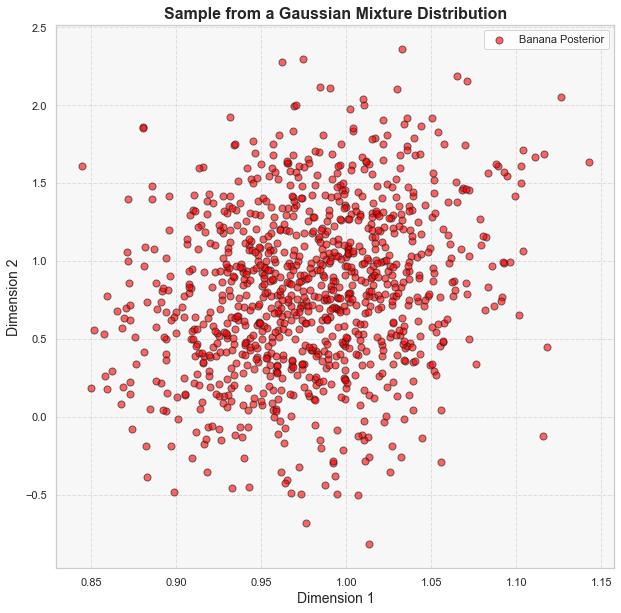

(array([[1.01659345, 0.7666396 ],
        [0.97134328, 0.26947132],
        [0.8831241 , 0.73522085],
        ...,
        [0.95389255, 0.93998161],
        [0.92195644, 1.36840673],
        [0.99620057, 0.76026087]]),
 array([ 1.01922997, -0.00258152]),
 array([[ 0.20994302,  0.020075  ],
        [ 0.21701989,  0.03436264],
        [ 0.22205467,  0.04452781],
        ...,
        [ 1.01919867, -0.00255994],
        [ 1.01921643, -0.00256652],
        [ 1.01922997, -0.00258152]]))

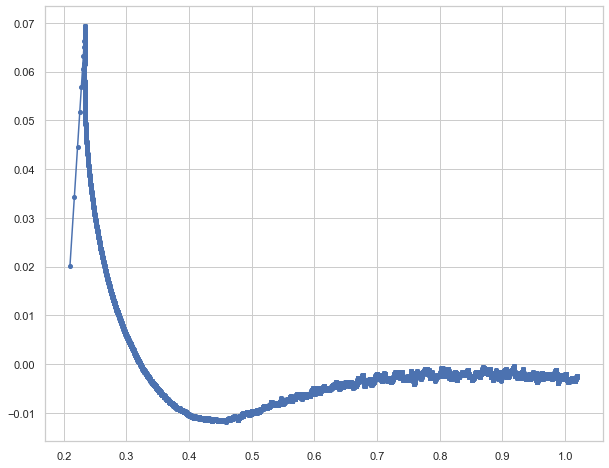

In [309]:
PGD_ban(1000, 35000, 0.0001, np.array([0.2, 0]), 0.05, 1, plot = True, sample_prior = sample_init, coeff_theta = 0.2)

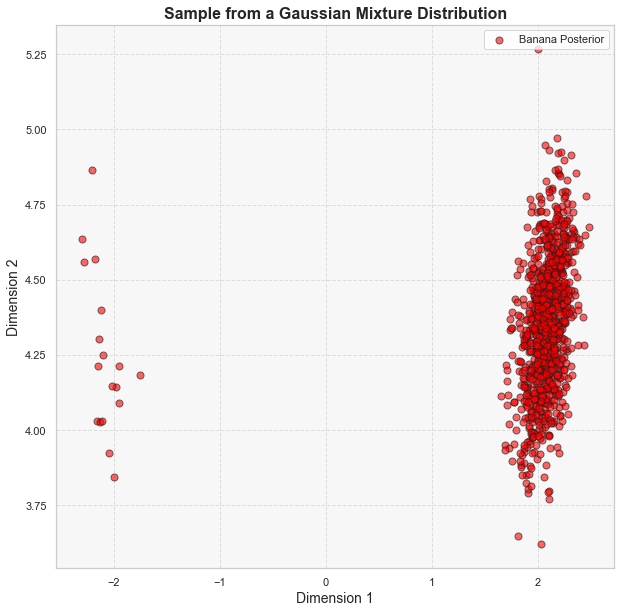

(array([[ 2.25197561,  4.63113821],
        [ 2.08831674,  4.4931528 ],
        [ 1.89298581,  4.31098043],
        ...,
        [ 2.10200987,  4.45144737],
        [-2.13816558,  4.30320246],
        [ 2.17175775,  4.22933368]]),
 array([0.00304665, 0.2280212 ]),
 array([[-0.16758234,  0.06576118],
        [-0.14463629,  0.11252976],
        [-0.12837825,  0.14579441],
        ...,
        [ 0.00306124,  0.22804581],
        [ 0.00305403,  0.22803475],
        [ 0.00304665,  0.2280212 ]]))

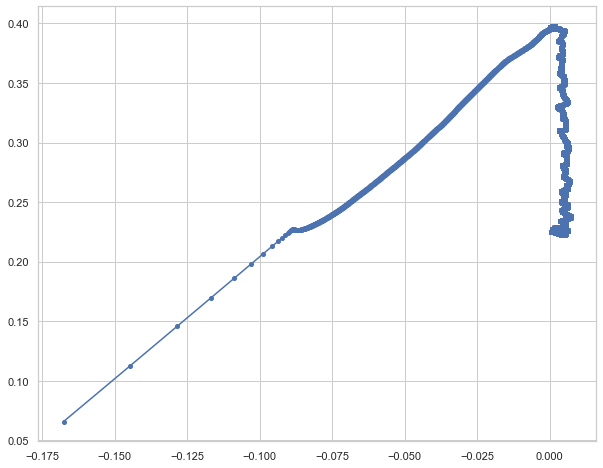

In [311]:
PGD_ban(1000, 35000, 0.0001, np.array([-0.2, 0]), 0.05, 1, plot = True, sample_prior = sample_init, coeff_theta = 0.2)

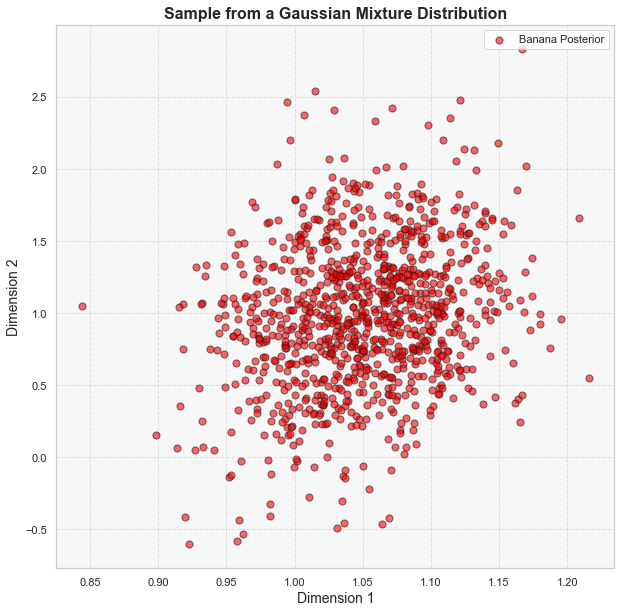

(array([[1.10962011, 1.04135471],
        [0.97340732, 0.84940573],
        [1.03278488, 1.21351899],
        ...,
        [1.0213374 , 0.54606206],
        [1.05337381, 1.47886408],
        [1.08634276, 0.76276304]]),
 array([ 0.95022542, -0.00239585]),
 array([[ 0.20756113,  0.02671305],
        [ 0.20370668,  0.01262785],
        [ 0.205856  ,  0.01999835],
        ...,
        [ 0.95019376, -0.00238351],
        [ 0.95020881, -0.00239017],
        [ 0.95022542, -0.00239585]]))

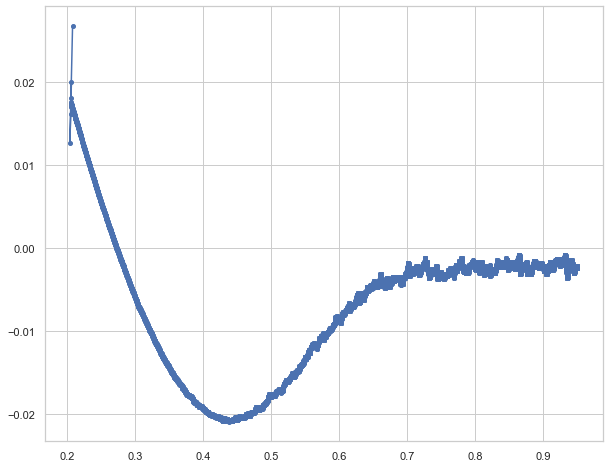

In [304]:
PGD_ban(1000, 25000, 0.0001, np.array([0.2, 0]), 0.05, 1, plot = True, sample_prior = sample_post, coeff_theta = 0.2)

------------------------------------------------------------------------------------------------------------------------------------------

Répartition des $\theta$ estimés, on remarque quelques zones de convergences mais restreintes et qui dépendent du theta initial : 

In [324]:
sample_prior = ULA_banana(np.random.randn(1000, 2), 50000, 0.001) ## Sample from prior

100%|██████████| 60/60 [09:12<00:00,  9.21s/it]


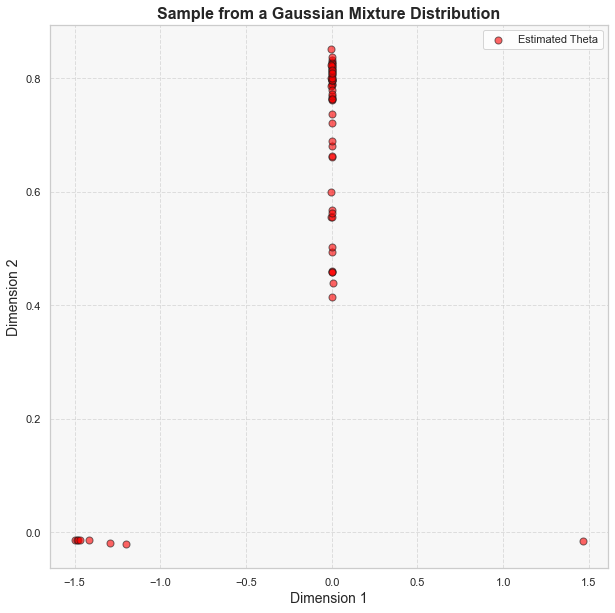

In [333]:
## Initialization of theta at origin
theta_estimated_list = np.zeros((60, 2))
theta_0_list = np.random.uniform(-0.5, 0.5, (60, 2))

for i in tqdm(range(60)):

    sample, theta_t, theta_traj = PGD_ban(1000, 25000, 0.0001, theta_0_list[i], 0.05, 1, plot = False, sample_prior = sample_prior)
    theta_estimated_list[i] = theta_t

plot_sample_dx(theta_estimated_list, 'Estimated Theta')

In [334]:
sample_prior = ULA_banana(np.random.randn(3000, 2), 25000, 0.001) ## Sample from prior
sample_noise = np.random.randn(3000) * sigma_y

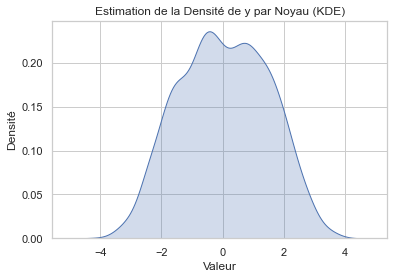

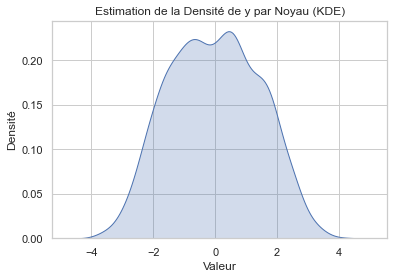

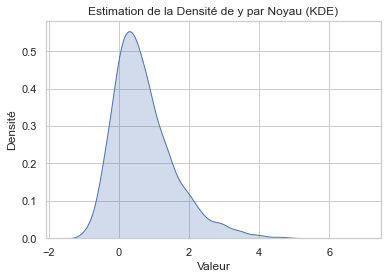

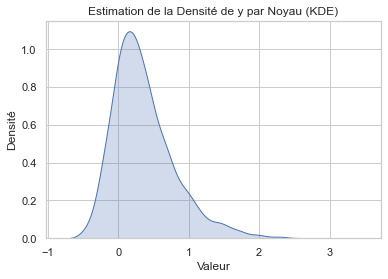

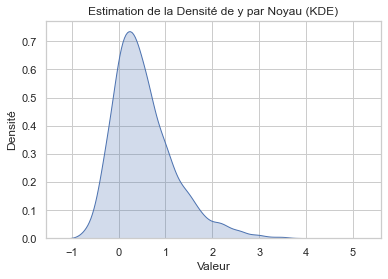

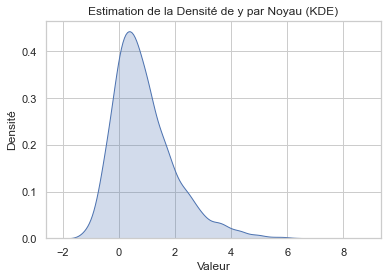

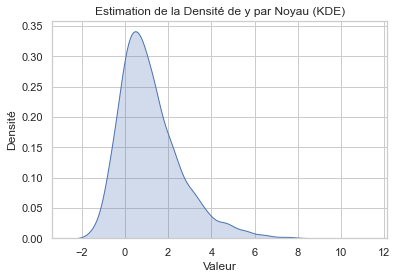

In [336]:
sample_obs = np.array([1.5, 0]) @ sample_prior.T + sample_noise

sns.kdeplot(sample_obs, fill=True)
plt.title('Estimation de la Densité de y par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

sample_obs = np.array([-1.5, 0]) @ sample_prior.T + sample_noise

sns.kdeplot(sample_obs, fill=True)
plt.title('Estimation de la Densité de y par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

sample_obs = np.array([0, 0.8]) @ sample_prior.T + sample_noise

sns.kdeplot(sample_obs, fill=True)
plt.title('Estimation de la Densité de y par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

sample_obs = np.array([0, 0.4]) @ sample_prior.T + sample_noise

sns.kdeplot(sample_obs, fill=True)
plt.title('Estimation de la Densité de y par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

sample_obs = np.array([0, 0.6]) @ sample_prior.T + sample_noise

sns.kdeplot(sample_obs, fill=True)
plt.title('Estimation de la Densité de y par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

sample_obs = np.array([0, 1]) @ sample_prior.T + sample_noise

sns.kdeplot(sample_obs, fill=True)
plt.title('Estimation de la Densité de y par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

sample_obs = np.array([0, 1.3]) @ sample_prior.T + sample_noise

sns.kdeplot(sample_obs, fill=True)
plt.title('Estimation de la Densité de y par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

Le fait de choisir un bas coefficient pour theta amène à converger vers des résultats différents, mais du coup vers les modes des mêmes zones de haute densité marginales. 

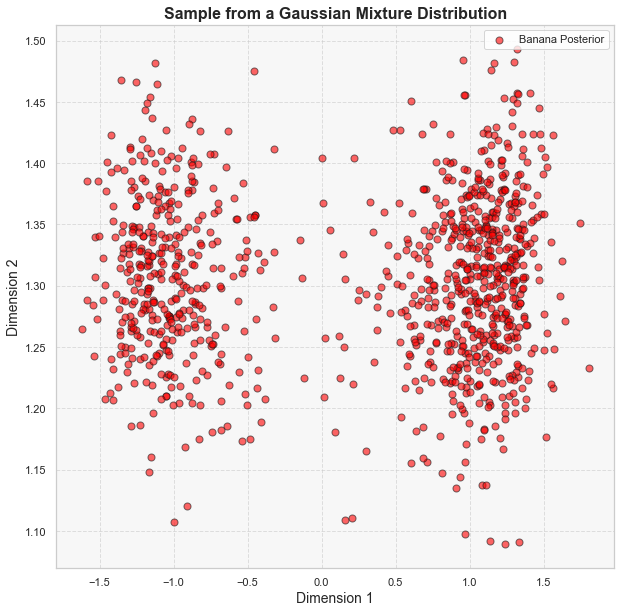

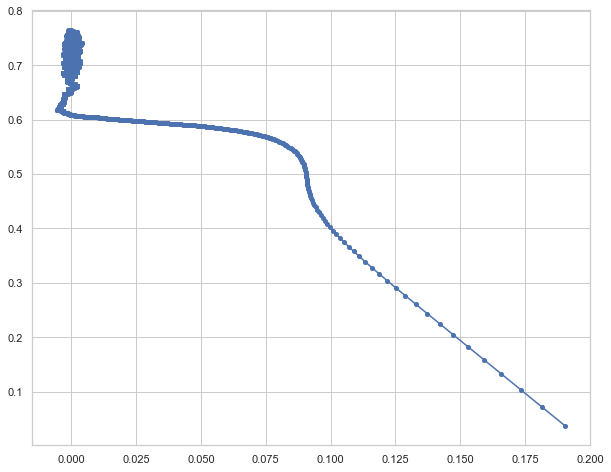

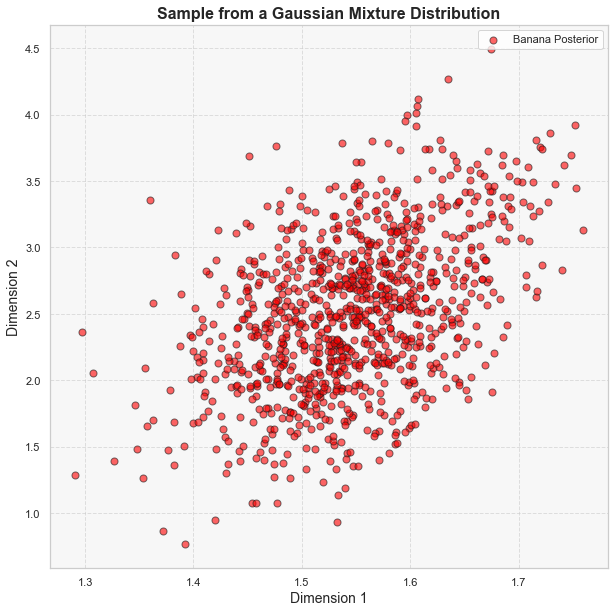

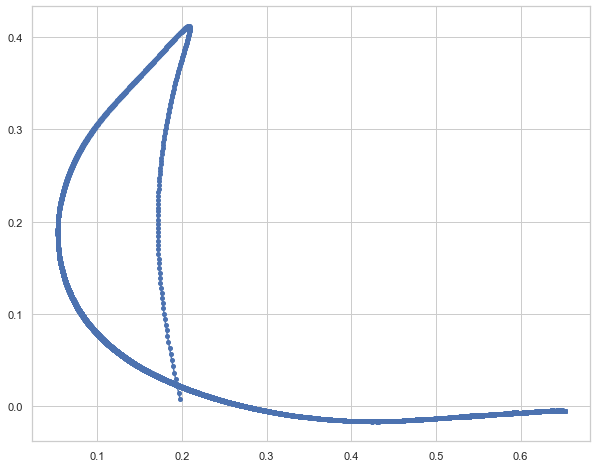

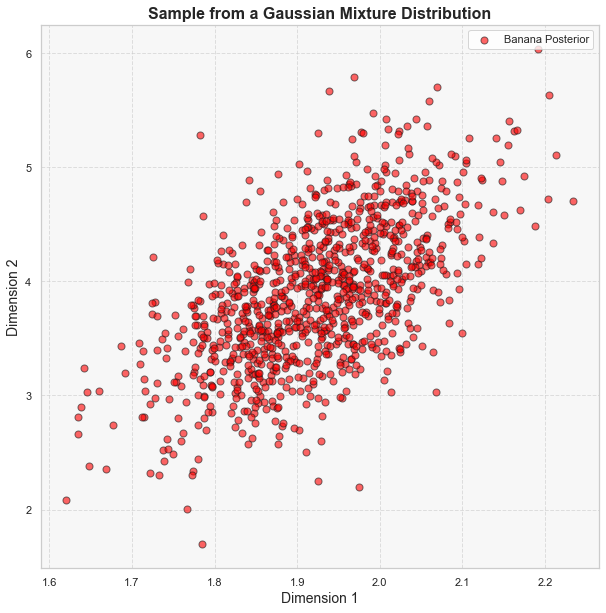

(array([[1.96538713, 3.3236347 ],
        [1.82750456, 3.87238608],
        [1.84540962, 3.18387758],
        ...,
        [1.74012525, 3.55134931],
        [1.86441229, 3.70606255],
        [1.95581941, 4.82541406]]),
 array([ 0.52749028, -0.00476081]),
 array([[ 0.19902286,  0.00377906],
        [ 0.19808695,  0.00751543],
        [ 0.1971896 ,  0.01121246],
        ...,
        [ 0.52745237, -0.00477219],
        [ 0.5274718 , -0.00476529],
        [ 0.52749028, -0.00476081]]))

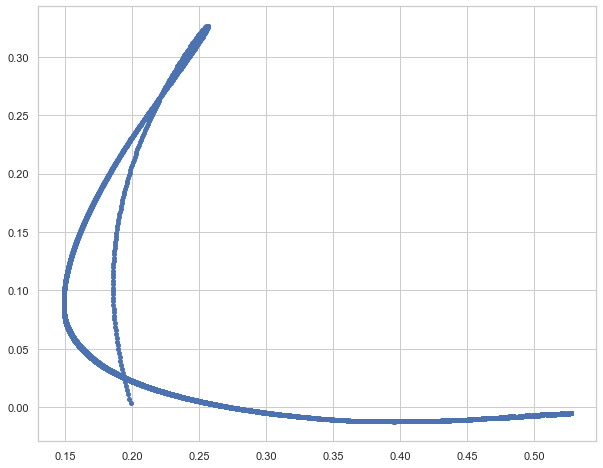

In [331]:
PGD_ban(1000, 25000, 0.0001, np.array([0.2, 0]), 0.05, 1, plot = True, sample_prior = sample_prior, coeff_theta=1)
PGD_ban(1000, 25000, 0.0001, np.array([0.2, 0]), 0.05, 1, plot = True, sample_prior = sample_prior, coeff_theta=0.2)
PGD_ban(1000, 25000, 0.0001, np.array([0.2, 0]), 0.05, 1, plot = True, sample_prior = sample_prior, coeff_theta=0.1)


On teste IPLA rapidement pour voir si cela change fondamentalement, mais a priori non et du coup le tout a l'air de fonctionner. On converge bien vers ce qui s'apparente au MML au vu de l'observation (qui du coup peut-être assez loin du vrai paramètre)

In [345]:

def IPLA_ban(nb_particles, nb_iter, step_size, H_0, sigma_y, y_obs, plot = False, sample_prior = None, coeff_theta = 1) : 

    theta_t = H_0

    dx = H_0.shape[0]

    if sample_prior is None :
        sample = ULA_banana(np.random.randn(nb_particles, dx), 25000, 0.001) ## Sample from prior
    else : 
        sample = np.copy(sample_prior)
    

    theta_traj = np.zeros((nb_iter, dx))

    for i in range(nb_iter) : 

        grad = grad_banana(sample)

        grad += (1/sigma_y**2) * theta_t * (y_obs - theta_t[:, np.newaxis].T * sample)

        sample += step_size * grad + np.sqrt(2*step_size) * np.random.randn(nb_particles, dx)

        ## MAJ du theta
        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) 

        theta_noise = np.sqrt(2 * step_size * coeff_theta / nb_particles) * np.random.randn(dx)

        theta_t = theta_t - (step_size * coeff_theta / nb_particles) * grad_theta_update + theta_noise

        theta_traj[i] = theta_t

        if np.sum(np.isnan(sample)) // dx > 0.9*nb_particles:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        plot_sample_dx(sample, 'Banana Posterior')

        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

    return sample, theta_t, theta_traj

In [346]:
sample_prior = ULA_banana(np.random.randn(1000, 2), 50000, 0.001) ## Sample from prior

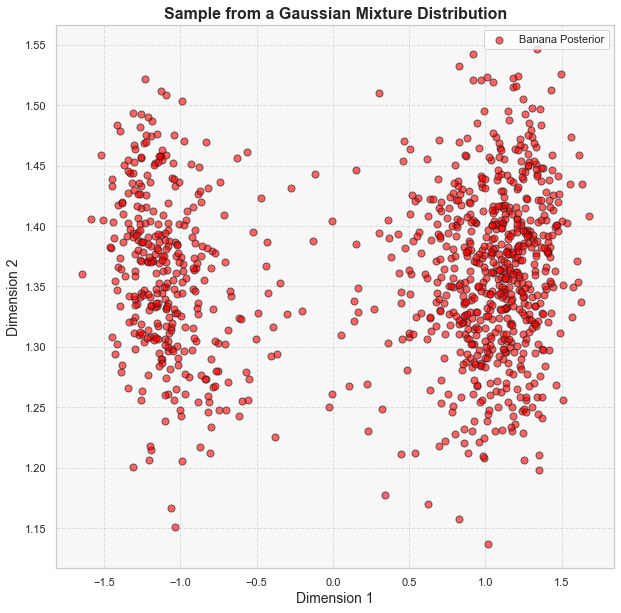

(array([[ 0.9396358 ,  1.37036734],
        [ 0.99385138,  1.20808175],
        [ 0.90963961,  1.34195905],
        ...,
        [ 0.73690069,  1.31033546],
        [ 1.38891778,  1.28407353],
        [-0.99378365,  1.3258432 ]]),
 array([-0.00162935,  0.7333325 ]),
 array([[ 0.1916289 ,  0.03719167],
        [ 0.18384944,  0.07153708],
        [ 0.17717802,  0.10314915],
        ...,
        [-0.00181066,  0.73356405],
        [-0.00157204,  0.73334743],
        [-0.00162935,  0.7333325 ]]))

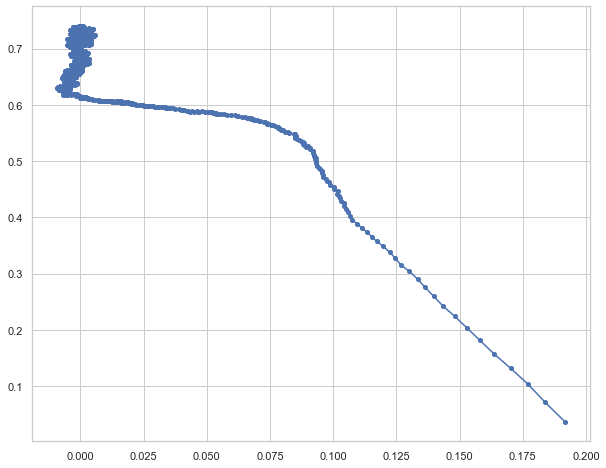

In [351]:
IPLA_ban(1000, 5000, 0.0001, np.array([0.2, 0]), 0.05, 1, plot = True, sample_prior = sample_prior, coeff_theta=1)

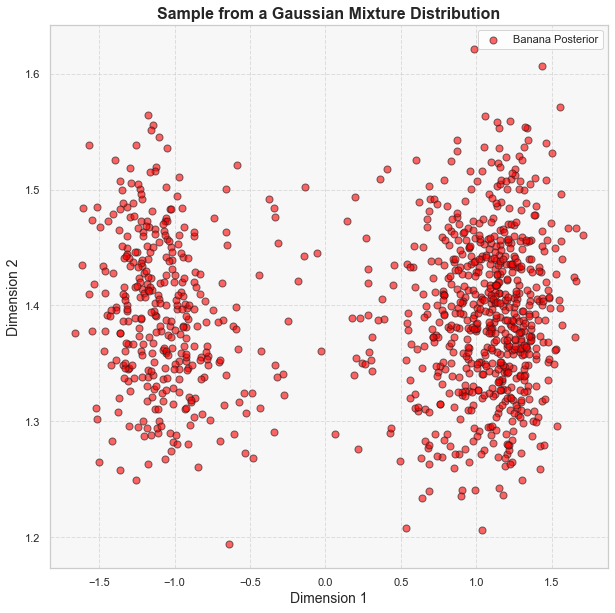

(array([[ 1.44364427,  1.36869515],
        [ 1.39184345,  1.47819988],
        [ 1.23274946,  1.50956507],
        ...,
        [ 1.1541508 ,  1.32694337],
        [-1.46518222,  1.36032498],
        [-0.78799709,  1.35338141]]),
 array([0.00084636, 0.71472461]),
 array([[0.19154758, 0.0370814 ],
        [0.18379668, 0.0709132 ],
        [0.17666874, 0.10183078],
        ...,
        [0.00077069, 0.71453621],
        [0.00079987, 0.71461731],
        [0.00084636, 0.71472461]]))

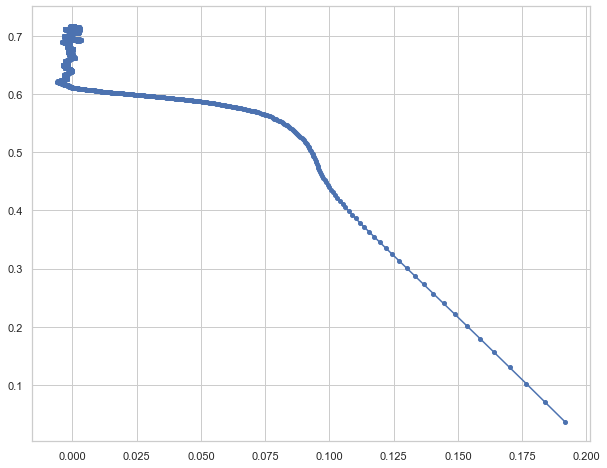

In [353]:
PGD_ban(1000, 5000, 0.0001, np.array([0.2, 0]), 0.05, 1, plot = True, sample_prior = sample_prior, coeff_theta=1)

OK donc IPLA se comporte de l'ultra même façon. Pas forcément besoin de mettre du Dilation là dedans. On essaye vite fait de trouver un exemple plus complexe, où la posterior est plus complexe par exemple pour voir si y aurait un intérêt. 

Non, donc on peut conclure que cette exemple n'aura servi à pas grand, si ce n'est voir comment agir sur le résultat dans le cadre d'un problème pas trop identifiable. Mais sinon, PGD et IPLA fonctionnent aussi bien que le mauvais chemin de dilatation. 